In [1]:
import os

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch import nn

from sklearn.model_selection import KFold

In [2]:
# Validation hyperparameters
args = {
    'n_folds': 5,
    'n_samples_per_fold': 200,
    'n_samples_total': 1000,
    'n_epochs': 500,
    'batch_size': 20,
    'learning_rate': 1e-2,
    
    'input_dim': 150,       # Set to crop length
    'hidden_dim': 50,
    'output_dim': 2,
    
    'training_mean': None,  # Used for normalization
    'training_std': None    # Used for normalization
}

# Useful files
validation_files = [f"cross_validation_fold{i}.csv" for i in range(1, args['n_folds'] + 1)]
test_file = "test_data.csv"

In [3]:
class SecondOrderDataset(Dataset):
    """ Second-Order System Dataset"""
    
    def __init__(self, csv_files, root_dir = '.', transform=None, training=True):
        """
        Args:
            csv_files (tuple, string): files we want to read in
            root_dir (string): Directory containing files we want to read
            transform (callable, optional): Transofrm to be applied on a sample
            training (bool): True if loading training data
        """
        
        # Load in all validation datasets and merge into numpy array
        self.data_csv = list()
        
        for fold in range(len(csv_files)):
            csv_file = csv_files[fold]
            csv_path = os.path.join(root_dir, csv_file)
                
            csv_data = pd.read_csv(csv_path).to_numpy()
            self.data_csv.append(csv_data)
            
        # normalize data to zero-mean, unit-variance
        self.data = np.vstack(tuple(self.data_csv))
        
        if training:
            mean = np.mean(self.data[:,0:2], axis = 0)
            stddev = np.std(self.data[:,0:2], axis = 0)
            args['training_mean'] = mean
            args['training_std'] = stddev

        # define transformations performed on retrieved data
        self.transform = transform
    
    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        targets = self.data[idx, 0:2]
        inputs = self.data[idx, 2:]
        
        # assert that we have 500 samples for each data point
        assert inputs.shape[-1] == 500
        
        sample = {'targets':targets, 'inputs':inputs}
        
        # convert to tensor, clip signal, etc.
        if self.transform:
            sample = self.transform(sample)
        
        return sample  

(zeta, wn) = [5.26315789e-02 1.31946891e+02], inputs = <class 'numpy.ndarray'>




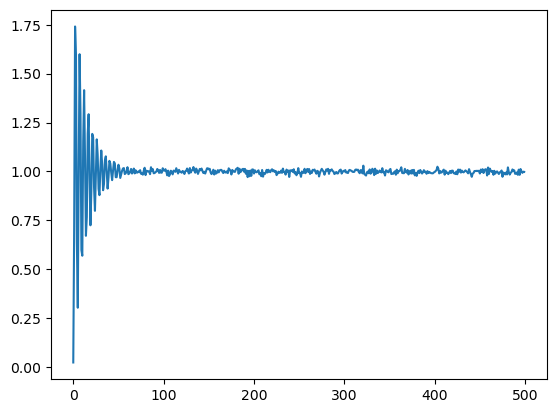

(zeta, wn) = [  0.21052632 144.51326207], inputs = <class 'numpy.ndarray'>




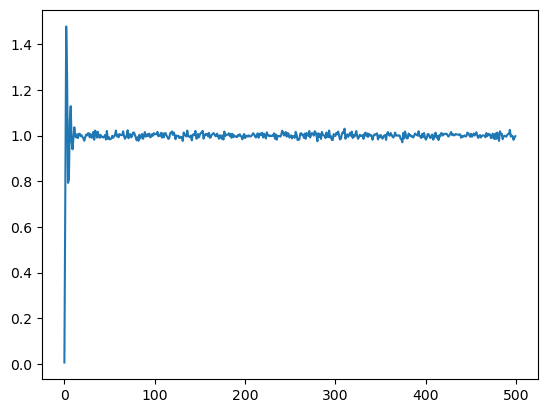

(zeta, wn) = [  0.31578947 125.66370614], inputs = <class 'numpy.ndarray'>




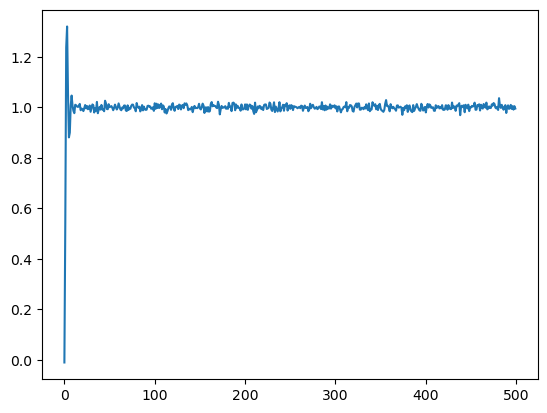

(zeta, wn) = [5.26315789e-02 2.82743339e+02], inputs = <class 'numpy.ndarray'>




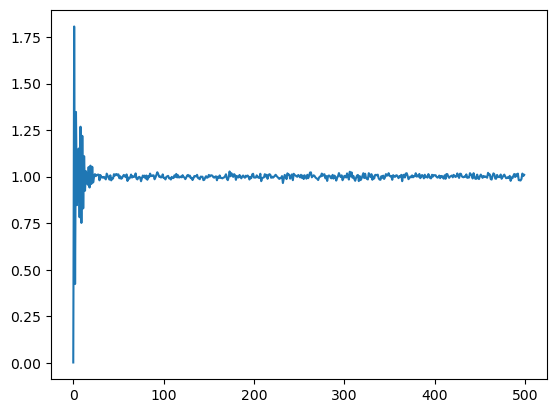

(zeta, wn) = [  0.63157895 276.46015352], inputs = <class 'numpy.ndarray'>




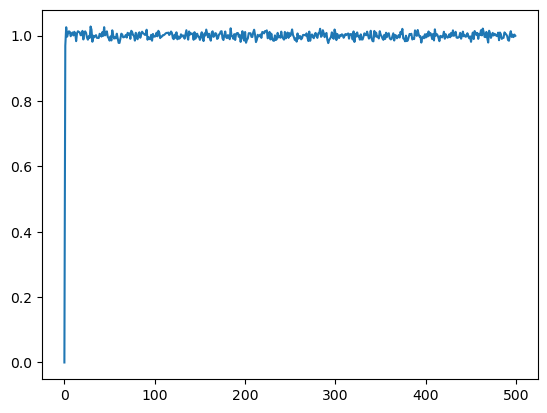

In [4]:
# Verify that dataset was loaded properly
csv_files = [f"cross_validation_fold{i}.csv" for i in range(1, args['n_folds'] + 1)]
second_order_dataset = SecondOrderDataset(csv_files=csv_files)

for i in range(len(second_order_dataset)):
    sample = second_order_dataset[i * args['n_samples_per_fold']]
    
    print(f"(zeta, wn) = {sample['targets']}, inputs = {type(sample['inputs'])}\n\n")
    plt.figure()
    plt.plot(sample['inputs'])
    plt.show()
    if i == args['n_folds'] - 1:

        break
        

In [38]:
# Define Normalize transformation
class Normalize(object):
    """ Normalize target tensor"""
    
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
        
    def __call__(self, sample):
        targets, inputs = sample.values()
        
        targets = (targets - self.mean) / self.std
        return {'targets': targets,
                'inputs': inputs}

# Define ToTensor transformation
class ToTensor(object):
    """ Convert ndarrays in sample to Tensors"""
    
    def __call__(self, sample):
        targets, inputs = sample.values()
        return{'targets': torch.from_numpy(targets).float(),
               'inputs': torch.from_numpy(inputs).float()}
    
# Define CropTo transformation
class CropTo(object):
    """ Crop input tensor"""
    
    def __init__(self, cropTo):
        self.cropTo = cropTo
        
    def __call__(self, sample):
        targets, inputs = sample.values()
        return{'targets': targets,
               'inputs': inputs[0:self.cropTo]}

# Define Fourier Transform transformation
class FourierTransform(object):
    """ Perform Fourier Transform on input data"""
    
    def __call__(self, sample):
        targets, inputs = sample.values()
        return {'targets': targets, 'inputs': torch.abs(torch.fft.fft(inputs)).float()}

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



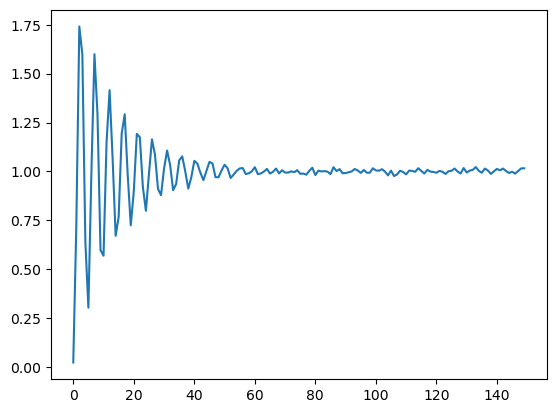

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



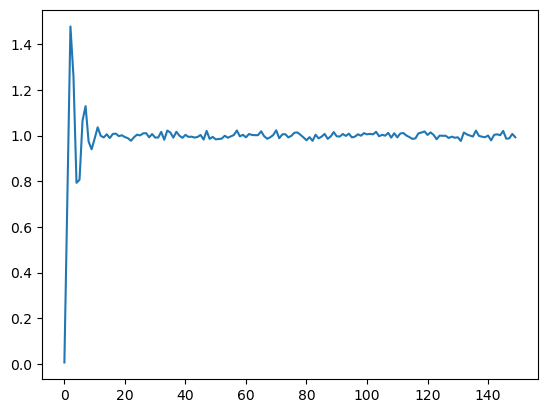

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



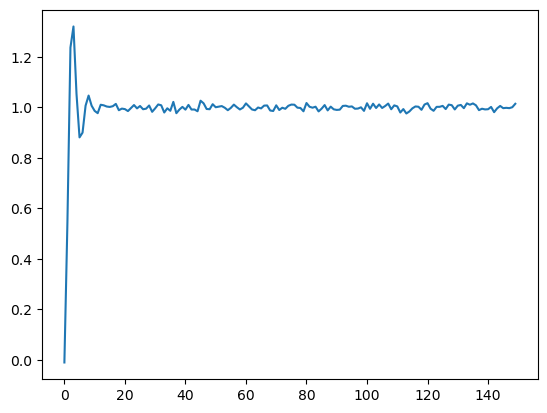

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



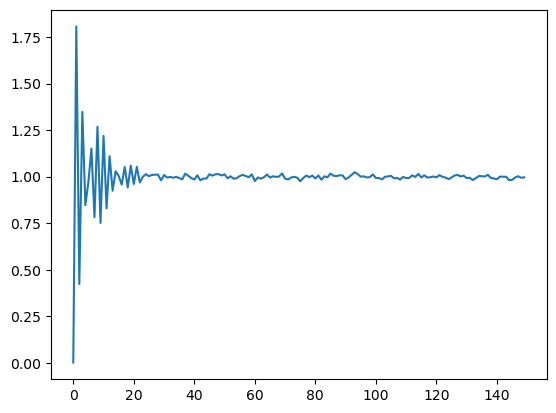

type(zeta, wn) = <class 'torch.Tensor'>, inputs = <class 'torch.Tensor'>



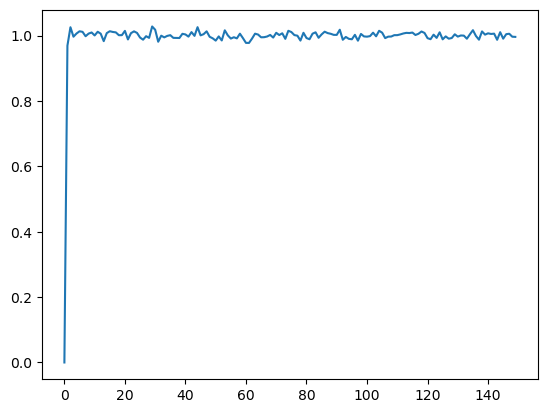

In [6]:
# Verify that dataset can be loaded as a Tensor and cropped
csv_files = [f"cross_validation_fold{i}.csv" for i in range(1, args['n_folds'] + 1)]
tsfrm = transforms.Compose([Normalize(args['training_mean'], args['training_std']),
                            ToTensor(), 
                            CropTo(args['input_dim'])])
second_order_dataset = SecondOrderDataset(csv_files=csv_files,
                                          transform=tsfrm)

for i in range(len(second_order_dataset)):
    
    sample = second_order_dataset[i * args['n_samples_per_fold']]
    
    print(f"type(zeta, wn) = {type(sample['targets'])}, inputs = {type(sample['inputs'])}\n")

    plt.figure()
    plt.plot(sample['inputs'].numpy())
    plt.show()
    if i == args['n_folds'] - 1: break

In [7]:
# Use sklearn.KFold to split the dataset into 5 folds for cross-validation
kfold = KFold(n_splits=args['n_folds'], shuffle=False)

for fold, (train_idx, test_idx) in enumerate(kfold.split(second_order_dataset)):
    print(f"Fold {fold}:")
    
    targets, inputs = second_order_dataset[test_idx[0]].values()
    print(f"\tFirst target: {targets.numpy()}, first input: {inputs.numpy().shape}")
    
    targets, inputs = second_order_dataset[test_idx[-1]].values()
    print(f"\tLast target: {targets.numpy()}, last input: {inputs.numpy().shape}\n")

Fold 0:
	First target: [-1.474087  -0.3118315], first input: (150,)
	Last target: [ 0.95382094 -0.5197192 ], last input: (150,)

Fold 1:
	First target: [-0.95382094 -0.17323974], first input: (150,)
	Last target: [-0.78039896 -0.3118315 ], last input: (150,)

Fold 2:
	First target: [-0.606977   -0.38112742], first input: (150,)
	Last target: [0.78039896 1.0740863 ], last input: (150,)

Fold 3:
	First target: [-1.474087  1.35127 ], first input: (150,)
	Last target: [-0.95382094  0.58901507], last input: (150,)

Fold 4:
	First target: [0.43355498 1.2819741 ], first input: (150,)
	Last target: [ 0.78039896 -1.6284535 ], last input: (150,)



In [8]:
# Set up neural network module
torch.manual_seed(42)
class NeuralNetwork(nn.Module):
    """
    Simple neural network
    """
    
    def __init__(self, input_dim = args['input_dim'], hidden_dim = args['hidden_dim'], output_dim = args['output_dim'], loss_fn = nn.MSELoss(), dropout = None):
        super().__init__()
        
        self.loss_fn = loss_fn
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.ReLU = nn.LeakyReLU(0.1)
        # ModuleList seems to spit out junk values, not sure why, so
        # I'll explicitly create linear layers instead
        self.layers = nn.Sequential(
                                    nn.Linear(self.input_dim, self.hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim, self.hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim, self.hidden_dim),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_dim, self.output_dim)
                                    )
        

        
        self.dropout = nn.dropout(dropout) if dropout is not None else None
        
        #self.reset_parameters()
        
    def forward(self, x):
        x = self.layers(x)

        return x
            
    def reset_parameters(self):
        for i, layer in enumerate(self.linears.children()):
            nn.init.uniform_(layer.weight)
            #print(f"Layer {i + 1} weights: {layer.weight}")

In [31]:
# Function to train and test neural network
def train_network(model, optimizer, args, trainloader, trainlossloader, testloader):
    """
    Train neural network on given training and test data.
    
    Args:
        model (NeuralNetwork): Instance of neural network class
        optimizer: Instance of torch.optim
        args (dict): Hyperparameters for training
        trainloader (torch.utils.data.DataLoader): Loader for training data in batches
        trainlossloader (torch.utils.data.DataLoader): Loader for training data in bulk
        testloader (torch.utils.data.DataLoader): Loader for test data in bulk
    """

    train_losses = []
    test_losses = []
    pred = []
    true = []
    
    for epoch in range(0, args['n_epochs']):

        print(f"Optimizing over epoch {epoch + 1} / {args['n_epochs']}", end='\r')

        # optimize over all batches in epoch
        for i, data in enumerate(trainloader, 0):
            targets, inputs = data.values()
            out = model(inputs)
            loss = model.loss_fn(out, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # see how model performs on training dataset after epoch  
        with torch.no_grad():
            for i, data in enumerate(trainlossloader, 0):
                targets, inputs = data.values()
                out = model(inputs)
                loss = model.loss_fn(out, targets)
                train_losses.append(np.sqrt(loss.item()))

        # see how model performs on test data
        with torch.no_grad():
            for i, data in enumerate(testloader,0):
                targets, inputs = data.values()
                out = model(inputs)
                loss = model.loss_fn(out, targets)
                test_losses.append(np.sqrt(loss.item()))
                
                if epoch == args['n_epochs'] - 1:
                    pred.append(out.detach().numpy())
                    true.append(targets.detach().numpy())
    
    pred = np.concatenate(pred)
    true = np.concatenate(true)
    #print(f"Pred = {pred}\ntype(pred) = {type(pred)}\nshape = {pred.shape}")
          
    # Plot training and test losses
    plt.figure()
    plt.title("Losses per epoch")
    plt.plot(train_losses, label=f"Training loss (RMSE)")  
    plt.plot(test_losses, label=f"Test loss (RMSE)")
    plt.xlabel(f"Epoch # (Batch Size = {args['batch_size']})")
    plt.ylabel("Loss")
    plt.legend()
    
    # Plot predicted values
    plt.figure()
    plt.subplot(2,1,1)
    plt.title("Predicted vs True Zeta Values (Normalized)")
    plt.plot(pred[:,0], label="Pred")
    plt.plot(true[:,0], label="True")
    plt.legend()
    plt.xlabel(f"Parameter")
    plt.ylabel("Value")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.title("Predicted vs True Wn Values (Normalized)")
    plt.plot(pred[:,1], label="Pred")
    plt.plot(true[:,1], label="True")
    plt.legend()
    plt.xlabel("Parameter")
    plt.ylabel("Value")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    print(f"Final Training RMSE: {train_losses[-1]}")
    print(f"Final Test RMSE: {test_losses[-1]}")


Fold 0
---------------------------------


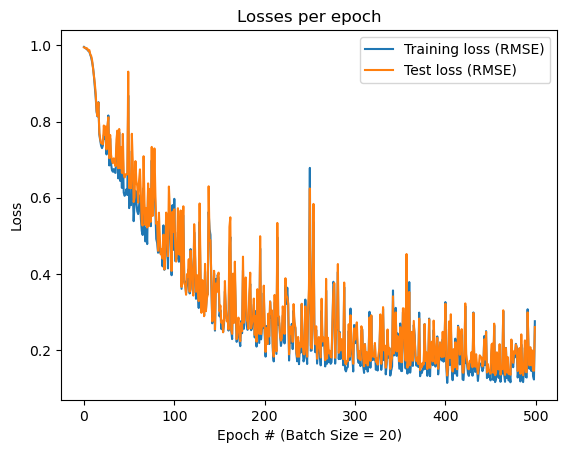

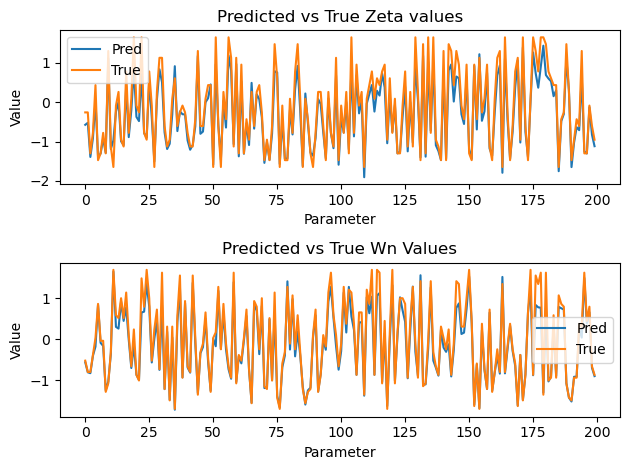

Final Training RMSE: 0.2757407053248188
Final Test RMSE: 0.2605923711582663

Fold 1
---------------------------------


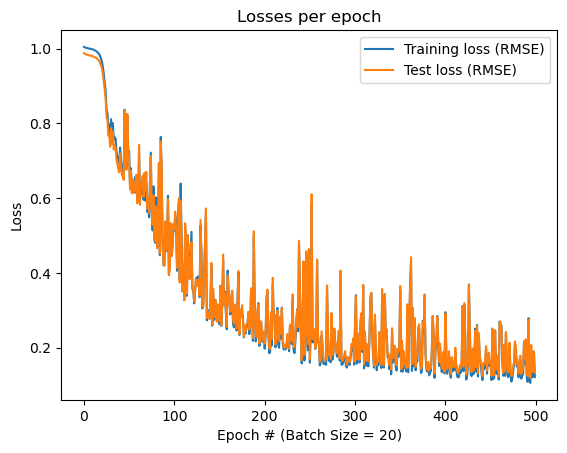

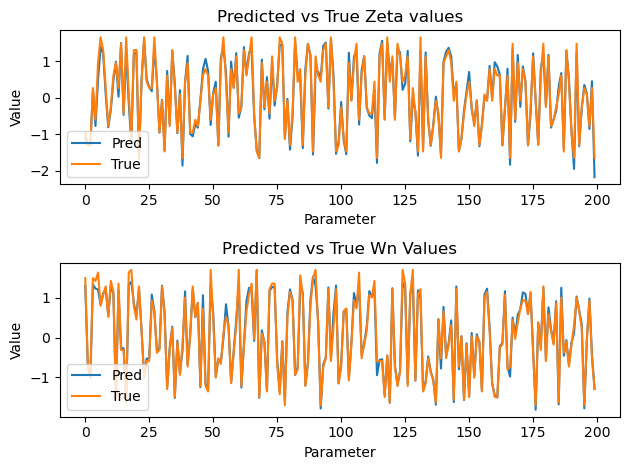

Final Training RMSE: 0.1215330316244274
Final Test RMSE: 0.13320600892466067

Fold 2
---------------------------------


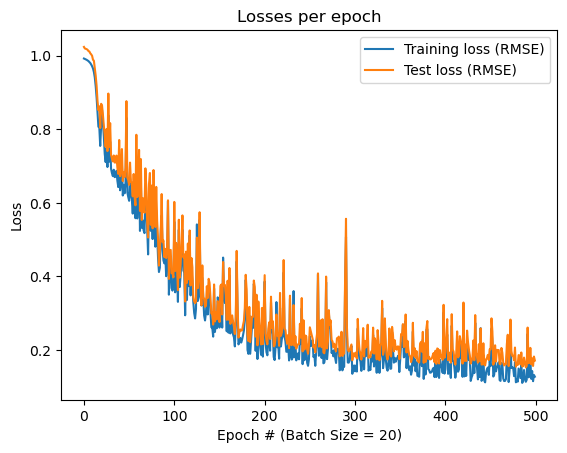

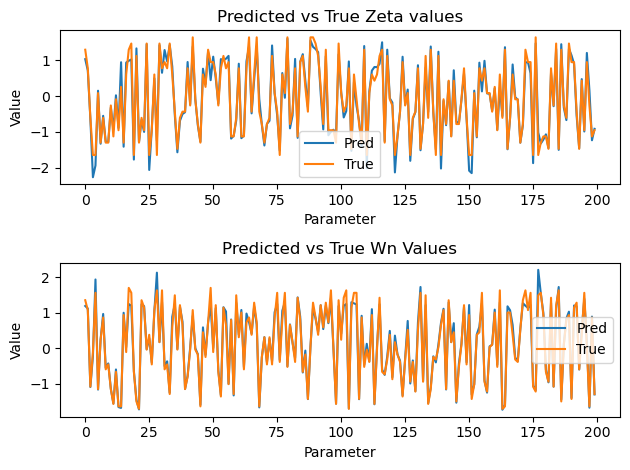

Final Training RMSE: 0.12701968868895894
Final Test RMSE: 0.1710418916521517

Fold 3
---------------------------------


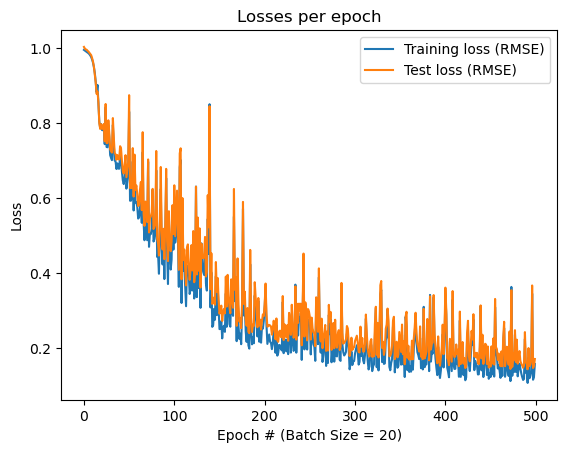

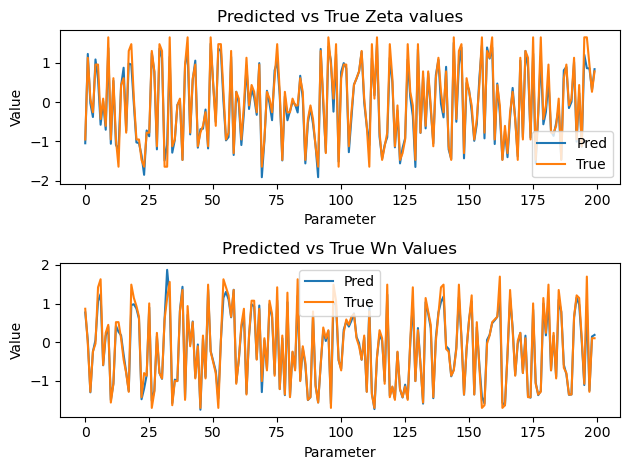

Final Training RMSE: 0.15686381295389035
Final Test RMSE: 0.17006905528475694

Fold 4
---------------------------------


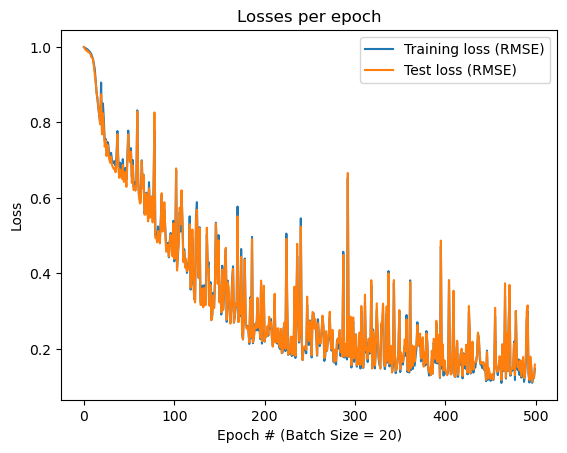

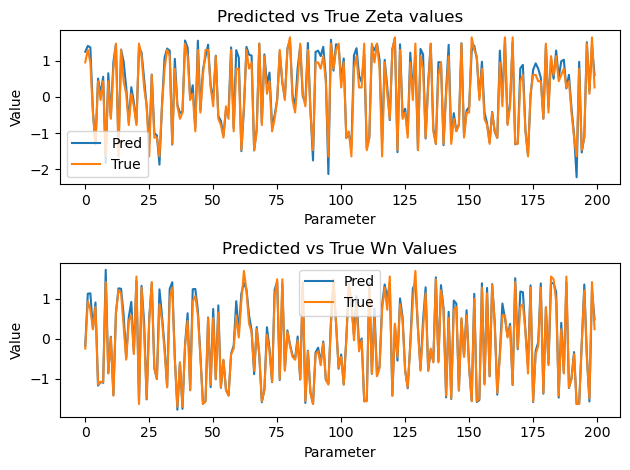

Final Training RMSE: 0.14785267415000428
Final Test RMSE: 0.15903588100353752


In [32]:
# Perform cross-validation
csv_files = [f"cross_validation_fold{i}.csv" for i in range(1, args['n_folds'] + 1)]
tsfrm = transforms.Compose([Normalize(args['training_mean'], args['training_std']),
                            ToTensor(), 
                            CropTo(args['input_dim'])])
second_order_dataset = SecondOrderDataset(csv_files=csv_files,
                                          transform=tsfrm)

for fold, (train_idx, test_idx) in enumerate(kfold.split(second_order_dataset)):
    
    print(f"\nFold {fold}")
    print("---------------------------------")
    
    # Sample elements from train and test sets WITHOUT replacement
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
    
    # Define data loaders for train and test sets
    trainloader = torch.utils.data.DataLoader(second_order_dataset,
                                              batch_size=args['batch_size'],
                                              sampler = train_subsampler)
    
    trainlossloader = torch.utils.data.DataLoader(second_order_dataset,
                                                  batch_size=len(train_idx),
                                                  sampler = train_subsampler)
    
    testloader = torch.utils.data.DataLoader(second_order_dataset,
                                             batch_size=args['n_samples_per_fold'],
                                             sampler = test_subsampler)
    
    # Train and validate network
    model = NeuralNetwork()
    optimizer = torch.optim.SGD(model.parameters(), lr=args['learning_rate'])
    train_network(model, optimizer, args, trainloader, trainlossloader, testloader)

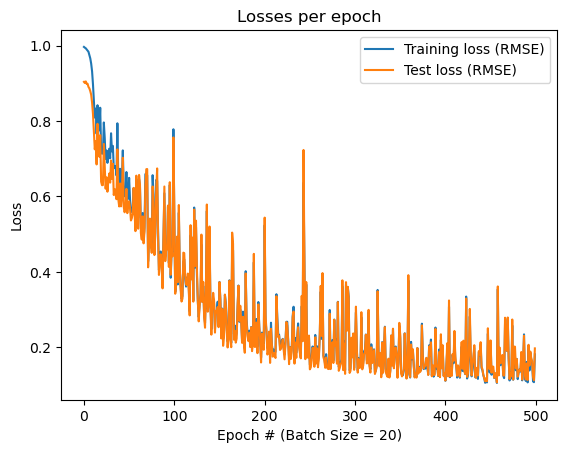

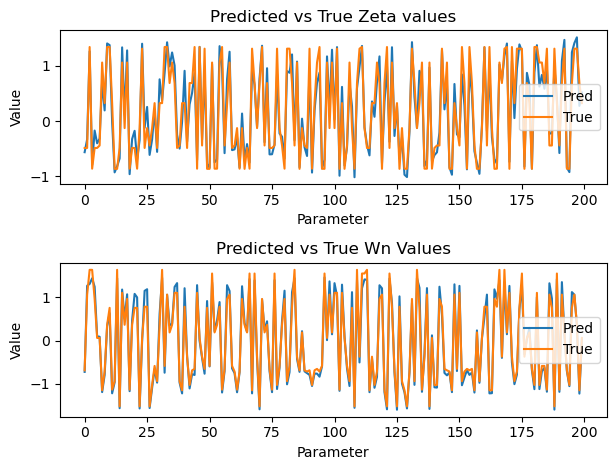

Final Training RMSE: 0.18121941242600179
Final Test RMSE: 0.19685619658032727


In [33]:
# Train model on all training data and test model on test data
train_files = [f"cross_validation_fold{i}.csv" for i in range(1, args['n_folds'] + 1)]
test_files = ["test_data.csv"]

tsfrm = transforms.Compose([Normalize(args['training_mean'], args['training_std']),
                            ToTensor(), 
                            CropTo(args['input_dim'])])

second_order_train_data = SecondOrderDataset(csv_files=train_files,
                                             transform=tsfrm)
second_order_test_data = SecondOrderDataset(csv_files=test_files,
                                            transform=tsfrm,
                                            training=False)

# Define data loaders for train and test sets
trainloader = torch.utils.data.DataLoader(second_order_train_data,
                                          batch_size=args['batch_size'],
                                          shuffle=True)

trainlossloader = torch.utils.data.DataLoader(second_order_train_data,
                                              batch_size=args['n_samples_total'],
                                              shuffle=True)

testloader = torch.utils.data.DataLoader(second_order_test_data,
                                         batch_size=args['n_samples_per_fold'],
                                         shuffle=True)

# Create, train, and test network
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=args['learning_rate'])
train_network(model, optimizer, args, trainloader, trainlossloader, testloader)

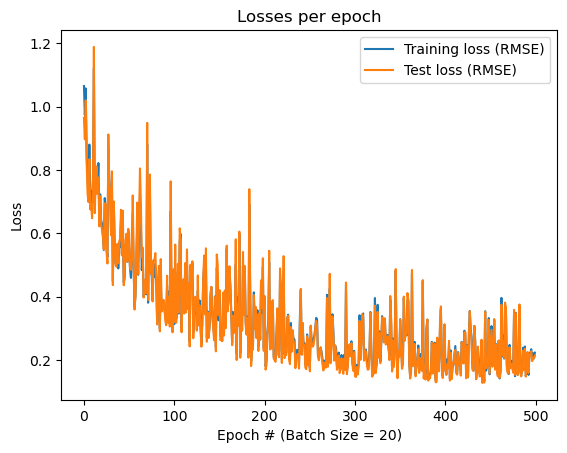

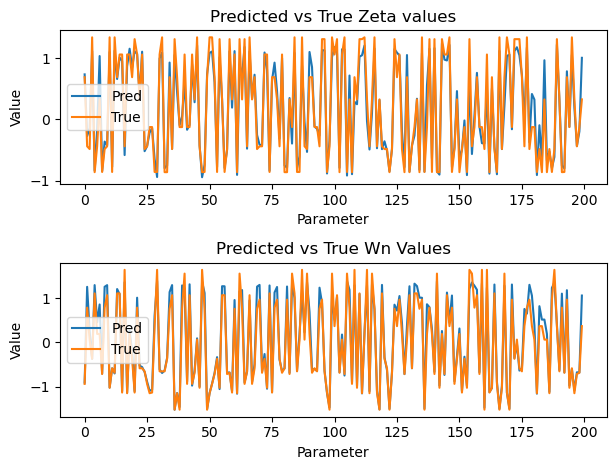

Final Training RMSE: 0.22317706649287608
Final Test RMSE: 0.21368236481129926


In [39]:
# Perform Fourier Transform on training data first
train_files = [f"cross_validation_fold{i}.csv" for i in range(1, args['n_folds'] + 1)]
test_files = ["test_data.csv"]

tsfrm = transforms.Compose([Normalize(args['training_mean'], args['training_std']),
                            ToTensor(), 
                            CropTo(args['input_dim']),
                            FourierTransform()])

second_order_train_data = SecondOrderDataset(csv_files=train_files,
                                             transform=tsfrm)
second_order_test_data = SecondOrderDataset(csv_files=test_files,
                                            transform=tsfrm,
                                            training=False)

# Define data loaders for train and test sets
trainloader = torch.utils.data.DataLoader(second_order_train_data,
                                          batch_size=args['batch_size'],
                                          shuffle=True)

trainlossloader = torch.utils.data.DataLoader(second_order_train_data,
                                              batch_size=args['n_samples_total'],
                                              shuffle=True)

testloader = torch.utils.data.DataLoader(second_order_test_data,
                                         batch_size=args['n_samples_per_fold'],
                                         shuffle=True)

# Create, train, and test network
model = NeuralNetwork()
optimizer = torch.optim.SGD(model.parameters(), lr=args['learning_rate'])
train_network(model, optimizer, args, trainloader, trainlossloader, testloader)